# טעינת וסקירת הנתונים
בקטע קוד זה, אנו טוענים את קובצי הנתונים ובודקים את השורות הראשונות של כל קובץ כדי להבין את המבנה שלהם.


In [10]:
import pandas as pd

# Load the datasets
targets_df = pd.read_csv('/content/data/lastfm_asia_target.csv')
edges_df = pd.read_csv('/content/data/lastfm_asia_edges.csv')

# Display the first few rows of each dataframe
print("Targets DataFrame:")
print(targets_df.head())

print("\nEdges DataFrame:")
print(edges_df.head())

Targets DataFrame:
   id  target
0   0       8
1   1      17
2   2       3
3   3      17
4   4       5

Edges DataFrame:
   node_1  node_2
0       0     747
1       1    4257
2       1    2194
3       1     580
4       1    6478
/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


# בניית הגרף
בקטע קוד זה, אנו יוצרים גרף ריק ומשתמשים בקובץ הקצוות להוספת הקצוות לגרף.


In [4]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add edges to the graph
for _, row in edges_df.iterrows():
    G.add_edge(row['node_1'], row['node_2'])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph has 7624 nodes and 27806 edges


# זיהוי קהילות
בקטע קוד זה, אנו משתמשים בשיטת Louvain לזיהוי קהילות בגרף ומוסיפים את המידע על הקהילות לנתוני המשתמשים.


In [5]:
import community.community_louvain as community_louvain

# Apply the Louvain method
partition = community_louvain.best_partition(G)

# Add partition information to the targets dataframe
targets_df['community'] = targets_df['target'].map(partition)

# Display the first few rows with community information
print(targets_df.head())


   id  target  community
0   0       8          2
1   1      17          3
2   2       3          5
3   3      17          3
4   4       5          0


# ניתוח קהילות
בקטע קוד זה, אנו מנתחים את הקהילות שנמצאו ובודקים את החלוקה הגיאוגרפית של המשתמשים בכל קהילה.


In [6]:
# Group by community and analyze the geographical distribution
community_analysis = targets_df.groupby('community')['id'].value_counts().unstack().fillna(0)
print(community_analysis)


id         0     1     2     3     4     5     6     7     8     9     ...  \
community                                                              ...   
0           0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0  ...   
1           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2           1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3           0.0   1.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   
5           0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0  ...   
7           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
8           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
22          0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   

id         7614  7615  7616  7617  7618  7619  7620  7621  7622

# ויזואליזציה של הגרף והקהילות
בקטע קוד זה, אנו מייצרים גרף המציג את הקהילות בצבעים שונים.

מסקנות מהצגת האמצע שלנו: להשתמש בצבעים לא דומים לקהילות



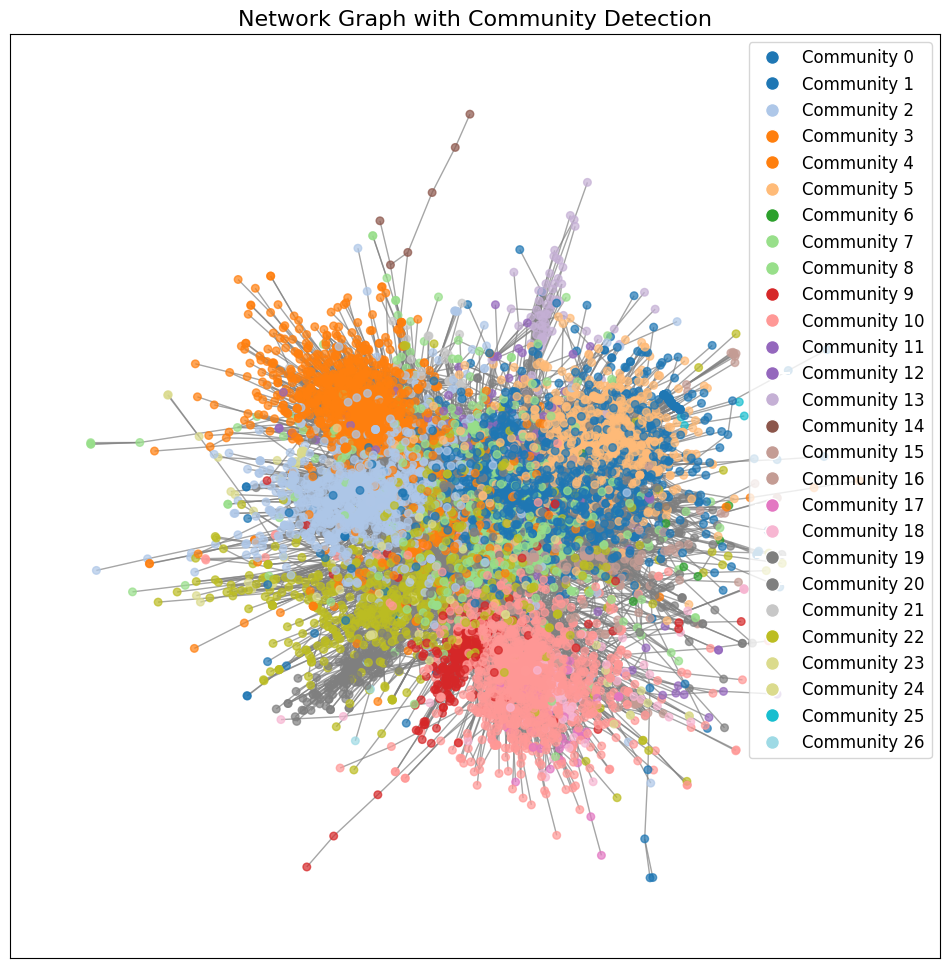

In [7]:
import matplotlib.pyplot as plt

# Draw the graph with community colors and legend
pos = nx.spring_layout(G)
cmap = plt.get_cmap('tab20')
unique_communities = set(partition.values())
colors = [cmap(i / len(unique_communities)) for i in range(len(unique_communities))]
color_map = {comm: colors[i] for i, comm in enumerate(unique_communities)}

node_colors = [color_map[partition[node]] for node in G.nodes]

plt.figure(figsize=(12, 12))
nx.draw_networkx(G, pos, node_color=node_colors, with_labels=False, node_size=30, edge_color='gray', alpha=0.7)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[comm], markersize=10)
           for comm in unique_communities]
labels = [f"Community {comm}" for comm in unique_communities]
plt.legend(handles, labels, loc='best', fontsize='large')

plt.title("Network Graph with Community Detection", fontsize=16)
plt.show()

**צמצום צמתים- השתמשות ב-Threshold:**

כדי לצמצם את הצמתים ולהפוך את הגרף לברור יותר, השתמשנו בטכניקות של סינון פרטים על בסיס מדדי דמיון. לדוגמה, בחרנו רק את הצמתים החשובים ביותר בכל קהילה וסיננו צמתים עם פחות קשרים.

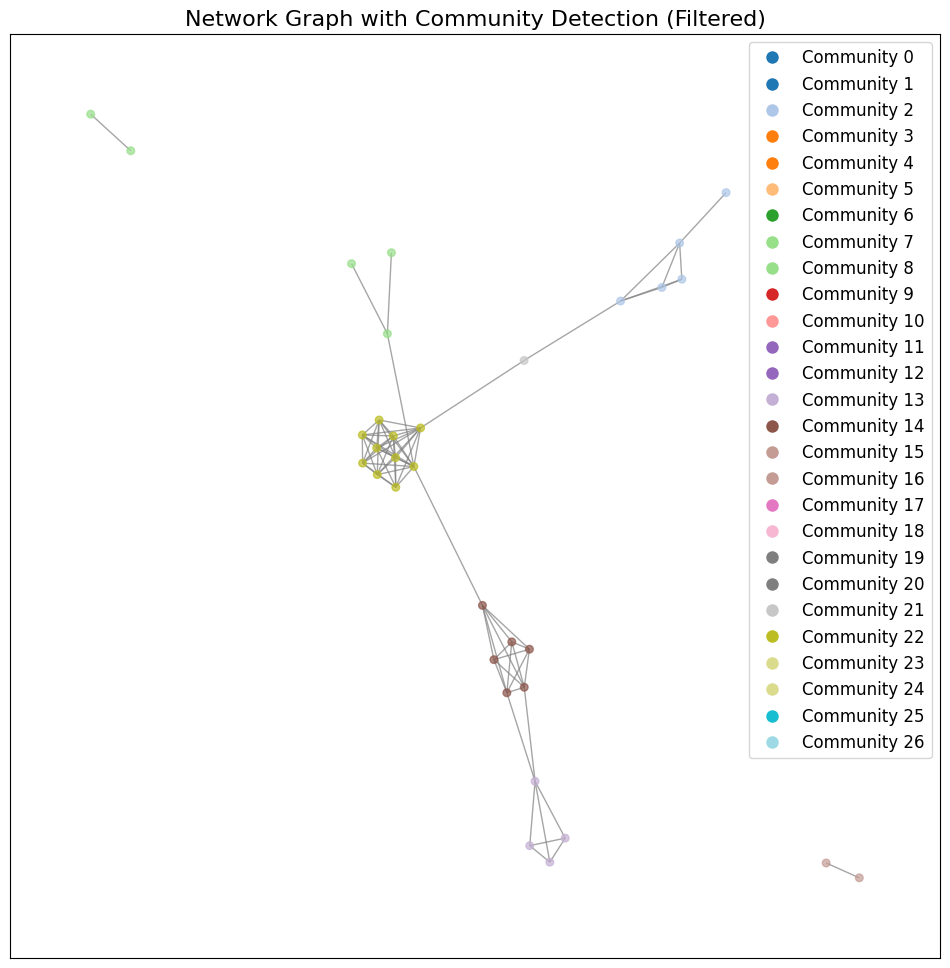

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain

# Apply the Louvain method
partition = community_louvain.best_partition(G)

# Get the degree centrality of nodes
degree_centrality = nx.degree_centrality(G)

# Define a threshold to filter nodes
threshold = 0.01  # This can be adjusted

# Filter nodes based on degree centrality
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality > threshold]

# Create a subgraph with filtered nodes
G_filtered = G.subgraph(filtered_nodes)

# Draw the graph with community colors and legend
pos = nx.spring_layout(G_filtered)
cmap = plt.get_cmap('tab20')
unique_communities = set(partition.values())
colors = [cmap(i / len(unique_communities)) for i in range(len(unique_communities))]
color_map = {comm: colors[i] for i, comm in enumerate(unique_communities)}

node_colors = [color_map[partition[node]] for node in G_filtered.nodes]

plt.figure(figsize=(12, 12))
nx.draw_networkx(G_filtered, pos, node_color=node_colors, with_labels=False, node_size=30, edge_color='gray', alpha=0.7)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[comm], markersize=10)
           for comm in unique_communities]
labels = [f"Community {comm}" for comm in unique_communities]
plt.legend(handles, labels, loc='best', fontsize='large')

plt.title("Network Graph with Community Detection (Filtered)", fontsize=16)
plt.show()

בקוד הבא השתמשנו בשני אתרי מחקר

אתר 1- מציג את הז'אנר שהפיקו אותו הכי הרבה במדינות באסיה בשנת 2019

אתר 2- מגיג את הז'אנרים המושמעים ביותר באסיה בשנת 2024

ייצרנו מפה אינטרקטיבית שמציגה כל מדינה באסיה מהאתרים עם הז'אנר המועדף עליה

In [ ]:
import folium

# Initialize map centered around Asia
m = folium.Map(location=[20, 100], zoom_start=4)

# Data for countries and their music genres
countries = {
    "China": "Rock, Pop",
    "Hong Kong": "Cantopop",
    "India": "Indian Pop, Bollywood",
    "Indonesia": "Dangdut, Rock",
    "Japan": "J-Pop, Downtempo/Experimental/Punk",
    "Nepal": "Folk, Ambient/Hindustani/New Age",
    "Singapore": "Pop, Punk",
    "South Korea": "K-Pop",
    "Sri Lanka": "Pop Rock/Vocal",
    "Vietnam": "V-Pop, Folk/Pop"
}

# Country coordinates for plotting
coords = {
    "China": [35.8617, 104.1954],
    "Hong Kong": [22.3193, 114.1694],
    "India": [20.5937, 78.9629],
    "Indonesia": [-0.7893, 113.9213],
    "Japan": [36.2048, 138.2529],
    "Nepal": [28.3949, 84.1240],
    "Singapore": [1.3521, 103.8198],
    "South Korea": [35.9078, 127.7669],
    "Sri Lanka": [7.8731, 80.7718],
    "Vietnam": [14.0583, 108.2772]
}

# Colors for each country
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'darkblue', 'darkgreen', 'cadetblue']

# Add markers for each country with genre and country name as tooltip and label
for idx, (country, genre) in enumerate(countries.items()):
    folium.Marker(
        location=coords[country],
        popup=genre,
        tooltip=country,
        icon=folium.Icon(color=colors[idx % len(colors)])
    ).add_to(m)
    folium.map.Marker(
        coords[country],
        icon=folium.DivIcon(
            icon_size=(300,36),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 16pt; color: {colors[idx]};"><b>{country}</b>: {genre}</div>',
        )
    ).add_to(m)

# Save the map to an HTML file
m.save("/mnt/data/asia_music_genres_updated_map_bold.html")

# Display the map
m
